In [19]:
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

tf.test.is_built_with_cuda()
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.config.experimental.list_logical_devices('GPU'))


2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np

## Fig 7 (top)
img_path  = 'inpainting/kate.png'
mask_path = 'inpainting/kate_mask.png'

## UTILS

In [38]:
from PIL import Image

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size. 

    Args: 
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np


def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d, 
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2), 
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped


from mpl_toolkits.axes_grid1 import ImageGrid
import math
def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid
    
    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure 
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"
    
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    lines = math.floor(len(images_np) / nrow)
    for ind, im in enumerate(images_np):
        plt.subplot(int(f'{lines}{nrow}{ind+1}'))
        if images_np[0].shape[0] == 1:
            plt.imshow(im[0], cmap='gray', interpolation=interpolation)
        else:
            plt.imshow(im.transpose(1, 2, 0), interpolation=interpolation)
    plt.show()

## PREPROCESSING

In [22]:
imsize = -1

img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

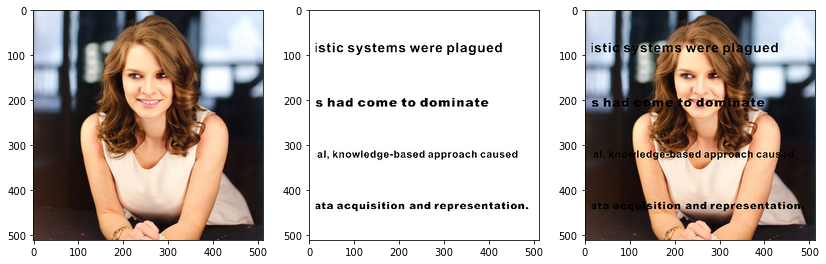

In [39]:
# center crop
dim_div_by = 64
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)


# visualize

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11)